## Autotagging projects
* Who is the lead agency? 
    * Agency in this project = the entity who is receiving funding for this project.
* Is this project on or off the SHS or both?
* Create a sentence to summarize this.

In [1]:
import pandas as pd

# Settings
pd.options.display.max_columns = 100
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:,.2f}".format

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/project_prioritization/"
FILE = "fake_data.xlsx"

# My utilities
import _utils
from calitp import *

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
# String manipulation
import re
from collections import Counter

import matplotlib.pyplot as plt  # plot package
import seaborn as sns  # statist graph package
import wordcloud  # will use for the word cloud plot
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import (  # optional to filter out the stopwords
    STOPWORDS,
    ImageColorGenerator,
    WordCloud,
)

### Preliminary Clean Up

In [3]:
# Read in file
df = to_snakecase(pd.read_excel(f"{GCS_FILE_PATH}{FILE}", sheet_name="fake"))

In [4]:
# Subset to columns I want.
df2 = df[
    [
        "project_name",
        "lead_agency",
        "project_description",
        "primary_mode",
        "secondary_mode_s",
        "shs_capacity_increase_detail",
    ]
]

#### Count Combos

In [5]:
# Count combos
combos = (
    df2.groupby(["primary_mode", "secondary_mode_s", "shs_capacity_increase_detail"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

In [6]:
# Find most commmon combos
combos.sort_values(["count"], ascending=False).head()

,primary_mode,secondary_mode_s,shs_capacity_increase_detail,count
171,Rail (Passenger),None,None,111
78,Highway,None,General Purpose Lane,62
10,Bike/Pedestrian,None,None,57
37,Grade Crossing,None,None,29
164,Rail (Freight),None,None,28


#### Count "None" Values for each column
* Around 2/3 of values are missing in secondary_mode & SHS. 
* Around 1/3 of values are missing for lead agencies. 

In [7]:
# How many none values are in the three columns
for i in [
    "primary_mode",
    "secondary_mode_s",
    "shs_capacity_increase_detail",
    "lead_agency",
    "project_description",
]:
    print((len((df2.loc[df2[i] == "None"])) / len(df2) * 100))

0.13458950201884254
66.21803499327052
62.0457604306864
31.090174966352624
6.191117092866756


### Are values in a column "highway related?"
* Search through primary mode, secondary mode, and SHS to see if they have highway-adjacent tags before searching through project descriptions.

In [8]:
def tagging_columns(
    df,
    tagging_col: str,
    new_col: str,
    keyword_list: list,
    true_keyword: str,
    false_keyword: str,
):
    """
    Search through a column for keywords.

    Args
    df: the dataframe.
    tagging_col (str): the column to search for the appearance of keywords.
    new_col (str): input whether or not the keyword was found.
    keyword_list (list): list of keywords to search through.
    true_keyword (str): replace "true" with a phrase that is more detailed.
    false_keyword (str): same as above, but with false.

    Returns: a dataframe with a new column stating whether
    the keyword(s) were found or not.
    """
    # Delinate items in keywords list using |.
    keywords = f"({'|'.join(keyword_list)})"

    # Lower the strings + strip excess white spaces.
    df[tagging_col] = df[tagging_col].str.lower().str.strip()

    # Create a new column that captures whether or not the keyword appears
    # Using str contains so interchange (new) and interchange (modifying) will appear.
    df["keyword_appears_bool"] = df[tagging_col].str.contains(keywords)

    # Function to categorize whether keyword was found.
    def keyword_found(row):
        if row["keyword_appears_bool"] == True:
            return true_keyword
        else:
            return false_keyword

    # Apply function and save results in a new column.
    df[new_col] = df.apply(lambda x: keyword_found(x), axis=1)

    # IF the original column wasn't populated and just says "none", replace the value in the
    # new column to accurately reflect this.
    df.loc[(df[tagging_col] == "none"), new_col] = "none"

    # Drop keyword col.
    df = df.drop(columns=["keyword_appears_bool"])

    return df

In [9]:
# Search through primary mode.
df3 = tagging_columns(
    df2,
    "primary_mode",
    "primary_mode_SHS",
    [
        "highway",
        "its",
        "interchange",
        "separation",
    ],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1854/4108280031.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1854/4108280031.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
/tmp/ipykernel_1854/4108280031.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_1854/4108280031.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [10]:
# Preview that this is correct
df3[["primary_mode", "primary_mode_SHS"]].drop_duplicates()

,primary_mode,primary_mode_SHS
0,complete streets,not highway related
1,bike/pedestrian,not highway related
2,transit,not highway related
3,highway,highway related
5,its,highway related
10,interchange (new),highway related
12,bridge,not highway related
14,zev,not highway related
26,local roadway,not highway related
30,interchange (modification),highway related


In [11]:
# Search through secondary mode.
df3 = tagging_columns(
    df3,
    "secondary_mode_s",
    "secondary_mode_SHS",
    ["highway", "lane", "interchange", "its", "separation"],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1854/4108280031.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [12]:
# Preview
df3[["secondary_mode_s", "secondary_mode_SHS"]].drop_duplicates()

,secondary_mode_s,secondary_mode_SHS
0,bike/pedestrian,not highway related
1,none,none
2,highway,highway related
4,bike/pedestrian\ncomplete streets,not highway related
5,its,highway related
7,zev,not highway related
12,bridge,not highway related
13,complete streets,not highway related
18,bike/pedestrian\nbridge,not highway related
19,bike/pedestrian\ncomplete streets\nits\ntransit,highway related


In [13]:
# Search through SHS Capacity Detail.
df3 = tagging_columns(
    df3,
    "shs_capacity_increase_detail",
    "shs_capacity_increase_detail_SHS",
    ["highway", "lane", "interchange"],
    "highway related",
    "not highway related",
)

/tmp/ipykernel_1854/4108280031.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [14]:
df3[
    [
        "shs_capacity_increase_detail",
        "shs_capacity_increase_detail_SHS",
    ]
].drop_duplicates()

,shs_capacity_increase_detail,shs_capacity_increase_detail_SHS
0,none,none
3,auxiliary lane,highway related
6,general purpose lane,highway related
8,transit/bus-only lane (addition),highway related
10,interchange (new),highway related
27,managed lane,highway related
44,managed lane (conversion),highway related
45,express lane (conversion),highway related
51,auxiliary lane\nmanaged lane (addition),highway related
52,managed lanes addition,highway related


### Check Out None Values
* As seen above, Secondary Mode & SHS Detail are missing 2/3 of their values. 
* However, primary mode is almost complete filled out.
* Evaluate how "complete" each project/row is for these 3 columns 
    * 45% of rows have one none value, 41% have 2...

In [15]:
# https://stackoverflow.com/questions/60446836/highlight-text-string-type-in-pandas-df-matching-text
# https://stackoverflow.com/questions/73839250/count-number-of-occurrences-of-text-over-row-python-pandas
# Count number of times "none" appears.
df3["none_count"] = df3[
    ["shs_capacity_increase_detail_SHS", "secondary_mode_SHS", "primary_mode_SHS"]
].apply(
    lambda x: sum([i.lower().count("none") for i in x if isinstance(i, str)]), axis=1
)

In [16]:
df3[["shs_capacity_increase_detail_SHS", "secondary_mode_SHS", "primary_mode_SHS","none_count"]].sample(3)

,shs_capacity_increase_detail_SHS,secondary_mode_SHS,primary_mode_SHS,none_count
320,none,highway related,not highway related,1
31,none,highway related,not highway related,1
117,highway related,none,highway related,1


In [17]:
(df3.none_count.value_counts() / len(df3)) * 100

1   45.36
2   41.32
0   13.19
3    0.13
Name: none_count, dtype: float64

### 1st Round of Tagging
* Determine who is the lead agency.
* Using the three categorical cols, try to tag whether this project is on/off the SHS. 
    

In [18]:
# Tag if the lead agency is Caltrans or a partner or unknown.
def CT_or_partner(row):
    # If partner is none, return Unknown.
    if row.lead_agency == "None":
        return "unknown"
        # If only Caltrans, return Caltrans
    if row.lead_agency == "Caltrans":
        return "Caltrans"
        # Everything else is a partner agency
    else:
        return "a partner"

In [19]:
# Apply the function
df3["caltrans_or_partner"] = df3.apply(CT_or_partner, axis=1)

In [20]:
def tagging_primary_secondary_SHS(df):

    """
    After applying the tagging_columns() to the three categorical columns (SHS Capacity Increase Detail,
    Secondary Mode SHS, and Primary Mode SHS), use the new true/false columsn
    to determine whether or not projects are on/off the SHS. If there are too many 'none' values,
    skip over tagging to combing through project descriptions.

    Args
    df: the dataframe.

    Returns: a dataframe tagging projects.
    """
    # Count number of times "none" appears for the three categorical columns by each project/row.
    # https://stackoverflow.com/questions/73839250/count-number-of-occurrences-of-text-over-row-python-pandas
    df["none_count"] = df[
        ["shs_capacity_increase_detail_SHS", "secondary_mode_SHS", "primary_mode_SHS"]
    ].apply(
        lambda x: sum([i.lower().count("none") for i in x if isinstance(i, str)]),
        axis=1,
    )

    # Begin tagging based on the three columns
    def on_SHS(row):
        
        # If primary mode is highway related and one other column is not highway related: not on the SHS
        if (row.primary_mode_SHS == "not highway related") and ((row.shs_capacity_increase_detail_SHS == "not highway related")|(row.secondary_mode_SHS == "not highway related")):
            return "not on the SHS"
        
         # If primary mode is highway related and one other column is not highway related: on the SHS
        elif (row.primary_mode_SHS == "highway related") and ((row.shs_capacity_increase_detail_SHS == "highway related")|(row.secondary_mode_SHS == "highway related")):
            return "on the SHS"
        
        # Everything else: 
        else:
            return "not enough info"

    # Apply the function
    df["on_off_shs_category_tags"] = df.apply(on_SHS, axis=1)

    return df

In [21]:
df4 = tagging_primary_secondary_SHS(df3)

In [22]:
# Check value counts.
(df4.caltrans_or_partner.value_counts() / len(df4)) * 100

a partner   47.11
unknown     31.09
Caltrans    21.80
Name: caltrans_or_partner, dtype: float64

In [23]:
# Check value counts.
df4.on_off_shs_category_tags.value_counts()

not enough info    365
on the SHS         274
not on the SHS     104
Name: on_off_shs_category_tags, dtype: int64

In [24]:
# Check value counts.
df4.on_off_shs_category_tags.value_counts() / len(df4) * 100

not enough info   49.13
on the SHS        36.88
not on the SHS    14.00
Name: on_off_shs_category_tags, dtype: float64

In [25]:
combos5 = (
    df4.groupby(
        [
            "on_off_shs_category_tags",
            "shs_capacity_increase_detail_SHS",
            "primary_mode_SHS",
            "secondary_mode_SHS",
        ]
    )
    .agg({"project_description": "count"})
    .reset_index()
    .rename(columns={"project_description": "total projects"})
    .reset_index(drop=True)
)

In [26]:
# https://stackoverflow.com/questions/60446836/highlight-text-string-type-in-pandas-df-matching-text
# https://stackoverflow.com/questions/73839250/count-number-of-occurrences-of-text-over-row-python-pandas
# Count number of times "none" appears.
combos5["none_count"] = combos5.apply(
    lambda x: sum([i.lower().count("none") for i in x if isinstance(i, str)]), axis=1
)

In [27]:
combos5.sort_values(by = ['on_off_shs_category_tags', 'total projects'], ascending = False).style.where(lambda val: "none" in str(val), "color: red")

/tmp/ipykernel_1854/85571598.py:1: FutureWarning: this method is deprecated in favour of `Styler.applymap()`


,on_off_shs_category_tags,shs_capacity_increase_detail_SHS,primary_mode_SHS,secondary_mode_SHS,total projects,none_count
12,on the SHS,highway related,highway related,none,178,1
11,on the SHS,highway related,highway related,highway related,59,0
13,on the SHS,highway related,highway related,not highway related,28,0
14,on the SHS,none,highway related,highway related,6,1
15,on the SHS,not highway related,highway related,highway related,3,0
8,not on the SHS,none,not highway related,not highway related,98,1
7,not on the SHS,highway related,not highway related,not highway related,4,0
9,not on the SHS,not highway related,not highway related,none,1,1
10,not on the SHS,not highway related,not highway related,not highway related,1,0
6,not enough info,none,not highway related,none,258,2


### Investigation:
* Around 42 percent have not enough info. Around 35 percent of values are "possibly on the SHS." 31 percent of projects are led by an unknown agency. Look through at these projects closer.
* Discern potential patterns in the three columns for these projects.


#### Most Common Words: Word Cloud
* https://www.kaggle.com/code/olgaberezovsky/word-cloud-using-python-pandas/notebook

In [28]:
extra_stop_words = [
    "project",
    "new",
    "improvement",
    "improve",
    "construct",
    "along",
    "improvements",
    "include",
    "will",
    "caltrans",
    "exist",
    "los angeles",
    "san diego",
    "near",
    "area",
    "south",
    "north" "street",
]

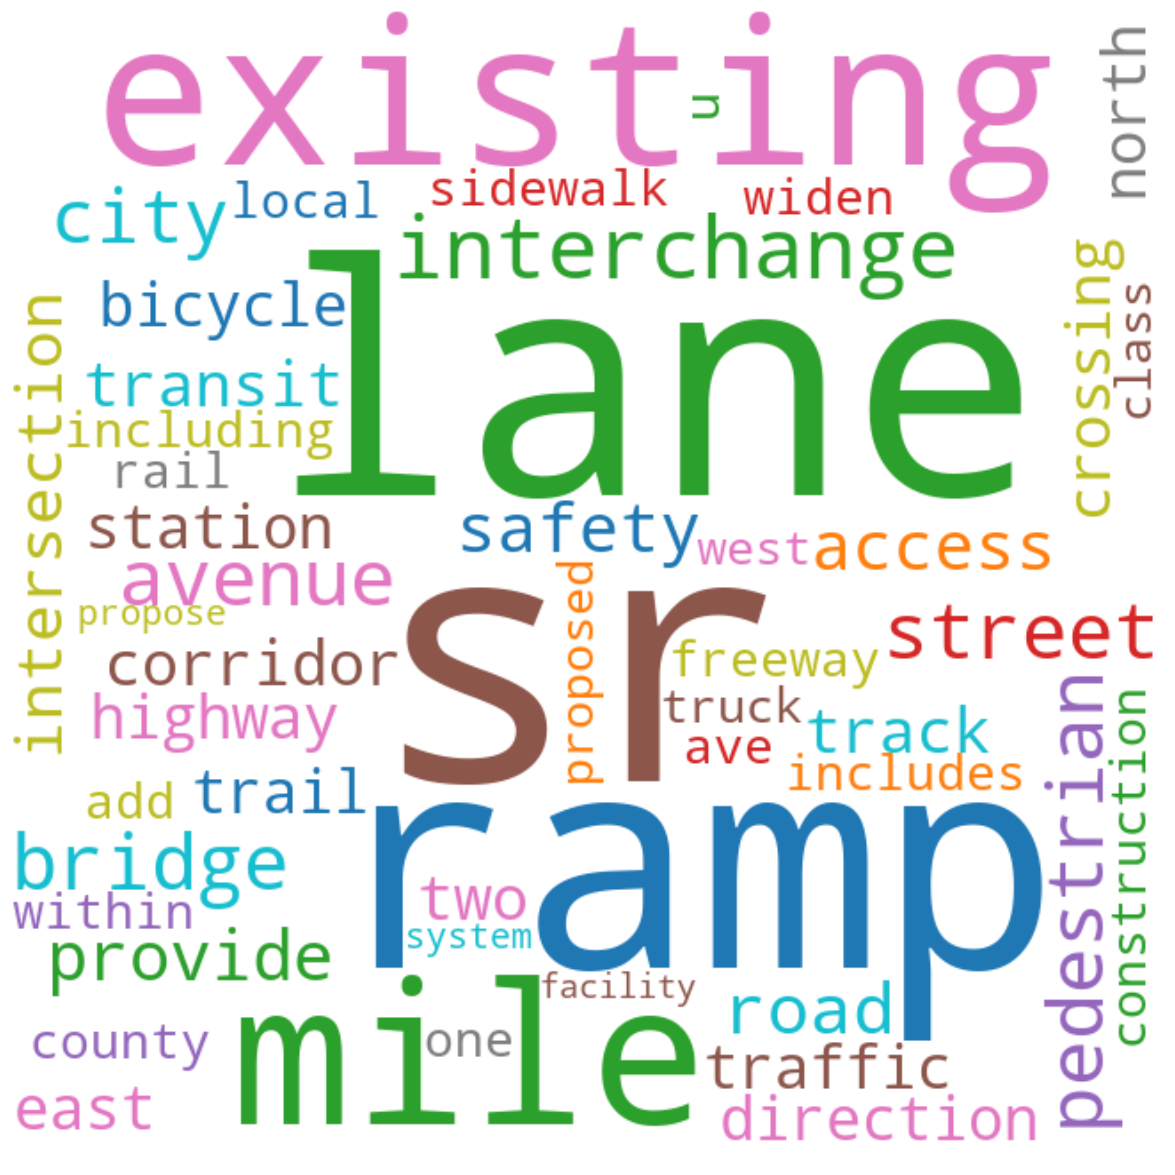

In [29]:
# Make a wordcloud of the top 100 words without certain stop words
_utils.wordcloud(df4, "project_description", 200, extra_stop_words)

#### Most Common Phrases
* Look through common phrases, in addition to single words. 

In [30]:
# Look for 2 word phrases through project desc
phrases = _utils.get_list_of_words(df4, "project_description", extra_stop_words)

In [31]:
df_phrases = _utils.common_phrases(df4, phrases, 2)

In [32]:
# df_phrases.head(50)

### Search through for SHS related words in project description 

In [33]:
# Keywords related to SHS - based on word cloud/common phrases results
SHS_keywords_list = [
    "sr",
    "state highway",
    "sr-",
    "state route",
    "sr ",
    "highway 1",
    "interstate",
    "us 101",
    "route 99",
    "sr 99",
    "i-",
    "us-",
    "u.s.",
    "101",
]

In [34]:
# Search through project description for keywords above
df5 = tagging_columns(
    df4,
    "project_description",
    "contains_SR_reference",
    SHS_keywords_list,
    "contains SHS keyword(s)",
    "does not contain SHS keyword(s)",
)

/tmp/ipykernel_1854/4108280031.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


In [35]:
df5.contains_SR_reference.value_counts()

contains SHS keyword(s)            366
does not contain SHS keyword(s)    331
none                                46
Name: contains_SR_reference, dtype: int64

In [36]:
# 46 projects have missing descriptions.
len(
    df5[["project_name", "project_description", "contains_SR_reference"]].loc[
        df5["contains_SR_reference"] == "none"
    ]
)

46

#### Investigate: projects that contain SHS keywords vs. those that don't.

In [37]:
# Extract keywords from project description that are in the list into a new col
# https://stackoverflow.com/questions/67746078/how-to-highlight-and-count-specific-keywords-in-a-pandas-dataframe
df5["SHS_keyword_match"] = df5["project_description"].str.findall(
    rf"\b(?:{'|'.join(SHS_keywords_list)})\b"
)

In [38]:
# Subset for a smaller df
subset_cols = [
    "project_name",
    "lead_agency",
    "project_description",
    "SHS_keyword_match",
    "on_off_shs_category_tags",
    "primary_mode",
    "contains_SR_reference",
    "SHS_keyword_match",
]

In [39]:
# Subset for projects with SHS keywords
SHS_keywords_df = (
    df5[subset_cols].loc[df5["contains_SR_reference"] == "contains SHS keyword(s)"]
).reset_index(drop=True)

In [40]:
# See which "not on the SHS" projects contain SHS keywords
len(SHS_keywords_df.loc[SHS_keywords_df["on_off_shs_category_tags"] == "not on the SHS"])

44

In [41]:
# Filter for values in SHS Keyword Match that are actually empty
# Replace this with "does not contain SHS Keywords"
# (SHS_keywords_df[SHS_keywords_df["SHS_keyword_match"].str.len() == 0])
# df.loc[(df["name"] == "Butte County Association of Governments"), "ntd_id"] = "90208"
# SHS_keywords_df.loc[ (SHS_keywords_df["SHS_keyword_match"].str.len() == 0), "contains_SR_reference"] = "does not contain SHS keyword(s)"

In [42]:
# Subset for projects without SHS keywords
no_SHS_keywords_df = (
    df5[subset_cols].loc[
        df5["contains_SR_reference"] == "does not contain SHS keyword(s)"
    ]
).reset_index(drop=True)

In [43]:
# Investigate why some "on the SHS" don't contain any SHS keywords in it's description...
len(no_SHS_keywords_df.loc[no_SHS_keywords_df['on_off_shs_category_tags'] == 'on the SHS'])

78

In [44]:
# no_SHS_keywords_df.loc[no_SHS_keywords_df['on_off_shs_category_tags'] == 'on the SHS']

### Retag using project descriptions

In [45]:
def SHS_project_description_tag(df):
    
    # Tag if a project's desc has a SHS keyword/SHS keywords or not
    def keywords(row):
        
        if ((row.on_off_shs_category_tags == "not on the SHS")|(row.on_off_shs_category_tags == "not enough info")) and (row.contains_SR_reference == "does not contain SHS keyword(s)"): 
            return "not on the SHS"
        
        elif ((row.on_off_shs_category_tags == "on the SHS")|(row.on_off_shs_category_tags == "not enough info")) and (row.contains_SR_reference == "contains SHS keyword(s)"):  
            return "on the SHS"
          
        # Some non SHS projects coincidentally include SHS keywords
        elif (row.on_off_shs_category_tags == "not on the SHS") and (row.contains_SR_reference == "contains SHS keyword(s)"):
            return "not on the SHS"
        
        # Some SHS projects don't have any SHS keywords in its description
        elif (row.on_off_shs_category_tags == "on the SHS") and (row.contains_SR_reference == "does not contain SHS keyword(s)"):
            return "on the SHS"
        # Everything else is too hard to determine
        else:
            return "not enough info"

    # Apply the function
    df["on_shs_project_desc_tag"] = df.apply(keywords, axis=1)

    # Create a summary sentence
    df["sentence"] = (
        "The lead agency is "
        + df["caltrans_or_partner"]
        + " and the project is "
        + df["on_shs_project_desc_tag"]
        + "."
    )

    return df

#### Compare first attempt of the sentence versus second attempt.

In [46]:
df6 = SHS_project_description_tag(df5)

In [47]:
# First round of tagging's results 
df5.on_off_shs_category_tags.value_counts()

not enough info    365
on the SHS         274
not on the SHS     104
Name: on_off_shs_category_tags, dtype: int64

In [48]:
# Second round of tagging's results
df6.on_shs_project_desc_tag.value_counts()

on the SHS         400
not on the SHS     297
not enough info     46
Name: on_shs_project_desc_tag, dtype: int64

In [49]:
# Goal to get rid of possibly on the SHS category?
(df6.on_shs_project_desc_tag.value_counts() / len(df6)) * 100

on the SHS        53.84
not on the SHS    39.97
not enough info    6.19
Name: on_shs_project_desc_tag, dtype: float64

In [50]:
# Cols for subsetting the df 
subset = [
        "project_description",
          "SHS_keyword_match",
        "primary_mode",
        "shs_capacity_increase_detail",
        "secondary_mode_s",
        "contains_SR_reference",
        "on_off_shs_category_tags",
        "on_shs_project_desc_tag",
  
    ]

In [51]:
combos6 = (
    df6.groupby(
        [ "on_shs_project_desc_tag","on_off_shs_category_tags", "contains_SR_reference"]
    )
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

In [52]:
# Compare first round with second round 
combos6["did_both_tagging_functions_give_same_result"] = (
    combos6["on_shs_project_desc_tag"] == combos6["on_off_shs_category_tags"]
)

In [53]:
combos6["did_both_tagging_functions_give_same_result"].value_counts()

True     5
False    4
Name: did_both_tagging_functions_give_same_result, dtype: int64

In [54]:
# First col is the new results after 2nd round of tagging 
combos6.sort_values(by = ["on_shs_project_desc_tag","count"], ascending=False)

,on_shs_project_desc_tag,on_off_shs_category_tags,contains_SR_reference,count,did_both_tagging_functions_give_same_result
7,on the SHS,on the SHS,contains SHS keyword(s),192,True
6,on the SHS,not enough info,contains SHS keyword(s),130,False
8,on the SHS,on the SHS,does not contain SHS keyword(s),78,True
3,not on the SHS,not enough info,does not contain SHS keyword(s),204,False
5,not on the SHS,not on the SHS,does not contain SHS keyword(s),49,True
4,not on the SHS,not on the SHS,contains SHS keyword(s),44,True
0,not enough info,not enough info,none,31,True
1,not enough info,not on the SHS,none,11,False
2,not enough info,on the SHS,none,4,False


#### Check out some combos. 
* Projects that were tagged as "not on the SHS" at first  but "contains SHS keywords"
* Projects that were tagged as "on the SHS" but "does not conatin SHS keywords"

In [55]:
(df6[subset][
    ((df6.on_off_shs_category_tags == "not on the SHS") & (df6.contains_SR_reference == "contains SHS keyword(s)" ))
]).sample(2)

,project_description,SHS_keyword_match,primary_mode,shs_capacity_increase_detail,secondary_mode_s,contains_SR_reference,on_off_shs_category_tags,on_shs_project_desc_tag
132,"the project will construct 1.3 miles of class 1 non-motorized pathway in and along the railroad row, directly connecting the surrounding neighborhood to bicycle faciltiies and the smart santa rosa north station with regional rail services north and south. the immediate area includes family educational destinations of the charles m. schulz museum and sonoma county children's museum along west steele lane. the project is within a regional priority development area and regional equity priority community and connects to major commercial and bus transit hubs at coddingtown mall.",[],bike/pedestrian,none,bike/pedestrian\ncomplete streets\nrail (passenger),contains SHS keyword(s),not on the SHS,not on the SHS
397,"this is a proposed complete-streets/multi-modal project which will construct more than eight (8) miles of ada-compliant sidewalks, 4 miles of class i and class ii multi-purpose trails/bike lanes, 16 miles of curb and gutter including raised median; four (4) miles of major street improvements; pedestrian crosswalks and countdown signal heads; medians with protected left turns; street lights; two (2) synchronized traffic signals; signal pre-emption technology; signage; bus turnouts; round-a-bout, low impact development (lid) catch basins and storm drains; sewer system; water lines; broadband conduit; and fire hydrants.\n\nremoved elements in the last application; would like to re-add the improvements row",[],complete streets,none,bike/pedestrian\ntransit,contains SHS keyword(s),not on the SHS,not on the SHS


In [56]:
(df6[subset][
    ((df6.on_off_shs_category_tags == "on the SHS") & (df6.contains_SR_reference == "does not contain SHS keyword(s)" ))
]).sample(2)

,project_description,SHS_keyword_match,primary_mode,shs_capacity_increase_detail,secondary_mode_s,contains_SR_reference,on_off_shs_category_tags,on_shs_project_desc_tag
470,"add a 4.2-mile long westbound auxiliary/truck climbing lane. relocate a class i bike lane. the improvements will reduce peak hour travel time and improve traffic flow for residents, freight, military personnel, emergency evacuation and response.",[],highway,auxiliary lane\ntruck climbing lane,bike/pedestrian,does not contain SHS keyword(s),on the SHS,on the SHS
416,convert four-lane expressway to six-lane freeway from 0.3 mile south of east atwater overhead to 0.5 miles north of west atwater overhead. reconstruct interchage at applegate rd.,[],highway,general purpose lane\ninterchange (modification),none,does not contain SHS keyword(s),on the SHS,on the SHS
